# Dataset 

In [1]:
import sys
sys.path.append('../datasets/')
from prepare_sequences import prepare, germanBats
import matplotlib.pyplot as plt

classes = germanBats

In [2]:
num_bands = 257
patch_len = 44                               # = 250ms ~ 25ms
patch_skip = patch_len / 2                   # = 150ms ~ 15ms
seq_len = 60                                 # = 500ms with ~ 5 calls
seq_skip = 15
resize = (64, 44)

X_train, Y_train, X_test, Y_test, X_val, Y_val = prepare("../datasets/prepared.h5", classes, patch_len, patch_skip,
                                                         seq_len, seq_skip, resize)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.07s/it]


In [3]:
print("Total sequences:", len(X_train) + len(X_test) + len(X_val))
print(X_train.shape, Y_train.shape)

Total sequences: 19494
(11482, 60, 44, 64) (11482,)


# Model

Sequence -> pos. encoding -> Transformer (CLS)

In [4]:
import time
import datetime
import numpy as np
import tqdm
import torch
import torch.nn as nn
import math
from torch.cuda.amp import autocast
from torch.utils.data import TensorDataset, DataLoader

sys.path.append('./addons/')
from sam import SAM
import einops
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

In [55]:
use_mixedprecision = False
use_sampler = True
use_reduceonplateu = True
use_cosinescheduler = False
use_sam = False

In [56]:
class PositionalEncoding(nn.Module):
    """
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model, max_len):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return x

In [57]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

In [58]:
class Net(nn.Module):
    """
    Classifier based on a pytorch TransformerEncoder.
    """

    def __init__(
        self,
        max_len,
        d_model,
        num_classes,
        nhead=8,
        dim_feedforward=2048,
        num_layers=6,
        dropout=0.1,
        classifier_dropout=0.1,
    ):

        super().__init__()

        assert d_model % nhead == 0, "nheads must divide evenly into d_model"

        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_encoder = nn.Parameter(torch.randn(1, max_len + 1, d_model))

        self.dropout = nn.Dropout(p=dropout)
        
        self.transformer_encoder = Transformer(
            dim=d_model,
            depth=num_layers,
            heads=nhead,
            dim_head=16,
            mlp_dim=dim_feedforward,
            dropout=dropout)
        
        self.classifier = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, num_classes))
        
        self.d_model = d_model

    def forward(self, x):       
        x = self.flatten(x)
        
        cls = einops.repeat(self.cls_token, '1 n d -> b n d', b=x.shape[0])
        x = torch.cat((cls, x), dim=1)
        x += self.pos_encoder
        
        x = self.dropout(x)
        x = self.transformer_encoder(x)
        
        x = x[:, 0]
        x = self.classifier(x)
        return x

In [59]:
def train_epoch(model, epoch, criterion, optimizer, scheduler, dataloader, device):
    model.train()
    
    running_loss = 0.0
    running_corrects = 0
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    for batch, (inputs, labels) in enumerate(tqdm.tqdm(dataloader)):
        # Transfer Data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
         
        # Clear the gradients
        optimizer.zero_grad()
        
        with autocast(enabled=use_mixedprecision):
            # Forward Pass
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            # Compute Loss
            loss = criterion(outputs, labels)
        
        # Calculate gradients
        loss.backward()
        
        # Update Weights
        if use_sam:
            optimizer.first_step()
            criterion(model(inputs), labels).backward()
            optimizer.second_step()
        else:
            optimizer.step()
        
        # Calculate Loss
        running_loss += loss.item() * inputs.size(0)
        running_corrects += (predictions == labels).sum().item()
    
        # Perform learning rate step
        if use_cosinescheduler:
            scheduler.step(epoch + batch / num_batches)
            
    epoch_loss = running_loss / num_samples
    epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

In [60]:
def test_epoch(model, epoch, criterion, optimizer, dataloader, device):
    model.eval()
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0

        for batch, (inputs, labels) in enumerate(tqdm.tqdm(dataloader)):
            # Transfer Data to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear the gradients
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            # Compute Loss
            loss = criterion(outputs, labels)

            # Calculate Loss
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (predictions == labels).sum().item()

        epoch_loss = running_loss / num_samples
        epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

In [61]:
from torchsampler import ImbalancedDatasetSampler

batch_size = 64
epochs = 50
lr = 1e-4
warmup_epochs = 5

train_data = TensorDataset(torch.Tensor(X_train), torch.from_numpy(Y_train))
test_data = TensorDataset(torch.Tensor(X_test), torch.from_numpy(Y_test))
val_data = TensorDataset(torch.Tensor(X_val), torch.from_numpy(Y_val))

if use_sampler:
    train_loader = DataLoader(train_data, sampler=ImbalancedDatasetSampler(train_data), batch_size=batch_size)
    test_loader = DataLoader(test_data, sampler=ImbalancedDatasetSampler(test_data), batch_size=batch_size)
    val_loader = DataLoader(val_data, sampler=ImbalancedDatasetSampler(val_data), batch_size=batch_size)
else:
    train_loader = DataLoader(train_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    val_loader = DataLoader(val_data, batch_size=batch_size)

In [62]:
model = Net(
    max_len=seq_len,
    d_model=resize[0]*resize[1] if resize is not None else patch_len * num_bands, # patch_len * num_bands, # 44 * 257 = 11,308
    num_classes=len(list(classes)),
    nhead=2,
    dim_feedforward=64,
    num_layers=2,
    dropout=0.1,
    classifier_dropout=0.5,
)
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=[0, 1])
model.to(device)
print(device)

cuda:0


In [63]:
import wandb

wandb.init(project="BAT-1", entity="frankfundel")

wandb.config = {
  "learning_rate": lr,
  "epochs": epochs,
  "batch_size": batch_size
}

criterion = nn.CrossEntropyLoss() # has softmax in it


if use_sam:
    base_optimizer = torch.optim.SGD
    optimizer = SAM(model.parameters(), base_optimizer, lr=lr, momentum=0.9)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
scheduler = None
if use_cosinescheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=warmup_epochs, T_mult=1)
if use_reduceonplateu:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
min_val_loss = np.inf

torch.autograd.set_detect_anomaly(True)

train_acc,▁▄▅▆▆▇▇▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁▁▁
val_acc,▁▅▆▇▇███████
val_loss,█▃▂▂▁▁▁▁▁▁▁▂
train_acc,0.94766
train_loss,0.2082
val_acc,0.69399
val_loss,1.09261


In [64]:
for epoch in range(epochs):
    end = time.time()
    print(f"==================== Starting at epoch {epoch} ====================", flush=True)
    
    train_loss, train_acc = train_epoch(model, epoch, criterion, optimizer, scheduler, train_loader, device)
    print('Training loss: {:.4f} Acc: {:.4f}'.format(train_loss, train_acc), flush=True)
    
    val_loss, val_acc = test_epoch(model, epoch, criterion, optimizer, val_loader, device)
    print('Validation loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc), flush=True)
    
    if use_reduceonplateu:
        scheduler.step(val_loss)
    
    wandb.log({
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
    })
    
    if min_val_loss > val_loss:
        print('val_loss decreased, saving model', flush=True)
        min_val_loss = val_loss
         
        # Saving State Dict
        torch.save(model.state_dict(), 'bat_1.pth')

==================== Starting at epoch 0 ====================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [01:18<00:00,  2.28it/s]

Training loss: 1.5209 Acc: 0.5387



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.28it/s]

Validation loss: 1.2490 Acc: 0.5871
val_loss decreased, saving model


==================== Starting at epoch 1 ====================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [01:13<00:00,  2.45it/s]

Training loss: 0.6070 Acc: 0.8065



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.68it/s]

Validation loss: 1.2117 Acc: 0.6247
val_loss decreased, saving model


==================== Starting at epoch 2 ====================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [01:13<00:00,  2.45it/s]

Training loss: 0.3357 Acc: 0.8951



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:04<00:00, 10.56it/s]

Validation loss: 1.2929 Acc: 0.6387
==================== Starting at epoch 3 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [01:07<00:00,  2.66it/s]

Training loss: 0.2155 Acc: 0.9354



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  5.80it/s]

Validation loss: 1.3933 Acc: 0.6247
==================== Starting at epoch 4 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [01:02<00:00,  2.87it/s]

Training loss: 0.1531 Acc: 0.9546



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:06<00:00,  6.91it/s]

Validation loss: 1.4750 Acc: 0.6329
==================== Starting at epoch 5 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [01:08<00:00,  2.64it/s]

Training loss: 0.1124 Acc: 0.9662



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  8.52it/s]

Validation loss: 1.4877 Acc: 0.6475
==================== Starting at epoch 6 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [01:00<00:00,  2.99it/s]

Training loss: 0.0795 Acc: 0.9761



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:06<00:00,  7.41it/s]

Validation loss: 1.6321 Acc: 0.6445
==================== Starting at epoch 7 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [01:01<00:00,  2.91it/s]

Training loss: 0.0601 Acc: 0.9836



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 13.84it/s]

Validation loss: 1.7129 Acc: 0.6329
==================== Starting at epoch 8 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:57<00:00,  3.11it/s]

Training loss: 0.0534 Acc: 0.9829



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:04<00:00, 10.18it/s]

Validation loss: 1.6941 Acc: 0.6294
==================== Starting at epoch 9 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:52<00:00,  3.41it/s]

Training loss: 0.0408 Acc: 0.9876



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 12.41it/s]

Validation loss: 1.9389 Acc: 0.6069
==================== Starting at epoch 10 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:53<00:00,  3.39it/s]

Training loss: 0.0362 Acc: 0.9895



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 13.14it/s]

Validation loss: 1.9057 Acc: 0.6301
==================== Starting at epoch 11 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:50<00:00,  3.54it/s]

Training loss: 0.0347 Acc: 0.9893



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.03it/s]

Validation loss: 1.9556 Acc: 0.6305
==================== Starting at epoch 12 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [01:00<00:00,  3.00it/s]

Training loss: 0.0297 Acc: 0.9918



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 13.07it/s]

Validation loss: 1.9764 Acc: 0.6308
==================== Starting at epoch 13 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:57<00:00,  3.11it/s]

Training loss: 0.0212 Acc: 0.9935



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 16.91it/s]

Validation loss: 2.0262 Acc: 0.6475
==================== Starting at epoch 14 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:56<00:00,  3.17it/s]

Training loss: 0.0187 Acc: 0.9940



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.30it/s]

Validation loss: 1.9089 Acc: 0.6643
==================== Starting at epoch 15 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:57<00:00,  3.14it/s]

Training loss: 0.0152 Acc: 0.9966



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 19.12it/s]

Validation loss: 1.8825 Acc: 0.6742
==================== Starting at epoch 16 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:55<00:00,  3.25it/s]

Training loss: 0.0125 Acc: 0.9967



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.93it/s]

Validation loss: 1.8661 Acc: 0.6680
==================== Starting at epoch 17 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:55<00:00,  3.23it/s]

Training loss: 0.0107 Acc: 0.9978



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.91it/s]

Validation loss: 1.9393 Acc: 0.6633
==================== Starting at epoch 18 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:56<00:00,  3.20it/s]

Training loss: 0.0113 Acc: 0.9972



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  8.51it/s]

Validation loss: 1.9987 Acc: 0.6520
==================== Starting at epoch 19 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:59<00:00,  3.01it/s]

Training loss: 0.0133 Acc: 0.9967



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:04<00:00, 11.06it/s]

Validation loss: 1.7245 Acc: 0.6779
==================== Starting at epoch 20 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:56<00:00,  3.18it/s]

Training loss: 0.0112 Acc: 0.9972



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 11.52it/s]

Validation loss: 1.9338 Acc: 0.6677
==================== Starting at epoch 21 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:42<00:00,  4.27it/s]

Training loss: 0.0104 Acc: 0.9975



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 23.39it/s]

Validation loss: 1.9766 Acc: 0.6496
==================== Starting at epoch 22 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:42<00:00,  4.28it/s]

Training loss: 0.0107 Acc: 0.9978



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 17.43it/s]

Validation loss: 2.0165 Acc: 0.6400
==================== Starting at epoch 23 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:42<00:00,  4.25it/s]

Training loss: 0.0086 Acc: 0.9985



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 26.03it/s]

Validation loss: 2.0235 Acc: 0.6492
==================== Starting at epoch 24 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:41<00:00,  4.35it/s]

Training loss: 0.0104 Acc: 0.9972



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 15.51it/s]

Validation loss: 1.9550 Acc: 0.6452
==================== Starting at epoch 25 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:40<00:00,  4.41it/s]

Training loss: 0.0097 Acc: 0.9973



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 17.76it/s]

Validation loss: 1.9827 Acc: 0.6434
==================== Starting at epoch 26 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:39<00:00,  4.51it/s]

Training loss: 0.0110 Acc: 0.9971



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 20.98it/s]

Validation loss: 1.9896 Acc: 0.6465
==================== Starting at epoch 27 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:40<00:00,  4.46it/s]

Training loss: 0.0084 Acc: 0.9983



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 21.18it/s]

Validation loss: 1.9274 Acc: 0.6557
==================== Starting at epoch 28 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:41<00:00,  4.38it/s]

Training loss: 0.0090 Acc: 0.9982



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 21.76it/s]

Validation loss: 2.0344 Acc: 0.6332
==================== Starting at epoch 29 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:39<00:00,  4.59it/s]

Training loss: 0.0086 Acc: 0.9976



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 23.40it/s]

Validation loss: 1.9352 Acc: 0.6417
==================== Starting at epoch 30 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:39<00:00,  4.55it/s]

Training loss: 0.0095 Acc: 0.9975



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 20.40it/s]

Validation loss: 1.8963 Acc: 0.6499
==================== Starting at epoch 31 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:38<00:00,  4.67it/s]

Training loss: 0.0072 Acc: 0.9987



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 23.73it/s]

Validation loss: 1.8899 Acc: 0.6540
==================== Starting at epoch 32 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:37<00:00,  4.77it/s]

Training loss: 0.0076 Acc: 0.9985



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 24.55it/s]

Validation loss: 1.8608 Acc: 0.6629
==================== Starting at epoch 33 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:36<00:00,  4.88it/s]

Training loss: 0.0094 Acc: 0.9976



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 25.19it/s]

Validation loss: 2.1155 Acc: 0.6305
==================== Starting at epoch 34 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:38<00:00,  4.71it/s]

Training loss: 0.0087 Acc: 0.9977



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 19.65it/s]

Validation loss: 1.9395 Acc: 0.6506
==================== Starting at epoch 35 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:36<00:00,  4.97it/s]

Training loss: 0.0079 Acc: 0.9983



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 27.48it/s]

Validation loss: 2.0337 Acc: 0.6448
==================== Starting at epoch 36 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:38<00:00,  4.70it/s]

Training loss: 0.0090 Acc: 0.9978



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 28.86it/s]

Validation loss: 2.0575 Acc: 0.6417
==================== Starting at epoch 37 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:36<00:00,  4.95it/s]

Training loss: 0.0084 Acc: 0.9983



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 26.02it/s]

Validation loss: 2.0169 Acc: 0.6581
==================== Starting at epoch 38 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:36<00:00,  4.93it/s]

Training loss: 0.0088 Acc: 0.9984



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 29.64it/s]

Validation loss: 2.0436 Acc: 0.6397
==================== Starting at epoch 39 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:35<00:00,  5.06it/s]

Training loss: 0.0077 Acc: 0.9985



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 29.27it/s]

Validation loss: 2.0539 Acc: 0.6472
==================== Starting at epoch 40 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:35<00:00,  5.04it/s]

Training loss: 0.0107 Acc: 0.9968



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 28.42it/s]

Validation loss: 2.1907 Acc: 0.6366
==================== Starting at epoch 41 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:35<00:00,  5.08it/s]

Training loss: 0.0084 Acc: 0.9975



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 30.97it/s]

Validation loss: 1.9376 Acc: 0.6551
==================== Starting at epoch 42 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:36<00:00,  4.95it/s]

Training loss: 0.0078 Acc: 0.9980



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 28.89it/s]

Validation loss: 2.0604 Acc: 0.6411
==================== Starting at epoch 43 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:38<00:00,  4.69it/s]

Training loss: 0.0090 Acc: 0.9979



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 31.07it/s]

Validation loss: 1.9502 Acc: 0.6489
==================== Starting at epoch 44 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:36<00:00,  4.89it/s]

Training loss: 0.0090 Acc: 0.9979



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 29.02it/s]

Validation loss: 2.0462 Acc: 0.6499
==================== Starting at epoch 45 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:35<00:00,  5.02it/s]

Training loss: 0.0078 Acc: 0.9983



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 30.58it/s]

Validation loss: 1.9626 Acc: 0.6578
==================== Starting at epoch 46 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:37<00:00,  4.78it/s]

Training loss: 0.0095 Acc: 0.9978



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 29.03it/s]

Validation loss: 2.0258 Acc: 0.6489
==================== Starting at epoch 47 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:36<00:00,  4.98it/s]

Training loss: 0.0078 Acc: 0.9983



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 27.38it/s]

Validation loss: 1.9703 Acc: 0.6605
==================== Starting at epoch 48 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:37<00:00,  4.83it/s]

Training loss: 0.0094 Acc: 0.9979



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 28.98it/s]

Validation loss: 1.8328 Acc: 0.6673
==================== Starting at epoch 49 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:36<00:00,  4.95it/s]

Training loss: 0.0086 Acc: 0.9981



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 29.09it/s]

Validation loss: 1.9546 Acc: 0.6472


In [65]:
wandb.finish()

train_acc,▁▅▆▇████████████████████████████████████
train_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▄▆▆▅▄▄▄▅▆██▇▆▇▆▅▆▆▆▇▅▆▆▇▄▆▅▇▅▅▆▅▆▇▆▇▆
val_loss,▁▁▂▂▃▄▅▄▆▆▆▇▆▆▆▇▆▆▇▇▇▇▆▇▆▆▆▇▇▇▇▇█▆▇▆▆▇▆▆
train_acc,0.99808
train_loss,0.00863
val_acc,0.6472
val_loss,1.95464


In [66]:
model.load_state_dict(torch.load('bat_1.pth'))
compiled_model = torch.jit.script(model)
torch.jit.save(compiled_model, 'bat_1.pt')

NotSupportedError: Compiled functions can't take variable number of arguments or use keyword-only arguments with defaults:
  File "/tmp/ipykernel_3091996/4133895867.py", line 6
    def forward(self, x, **kwargs):
                          ~~~~~~~ <--- HERE
        return self.fn(self.norm(x), **kwargs)


In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

Y_pred = []
Y_true = []
corrects = 0

model.eval()

# iterate over test data
for inputs, labels in tqdm.tqdm(test_loader):
    output = model(inputs.cuda()) # Feed Network

    output = (torch.max(output, 1)[1]).data.cpu().numpy()
    Y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    Y_true.extend(labels) # Save Truth

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.15it/s]


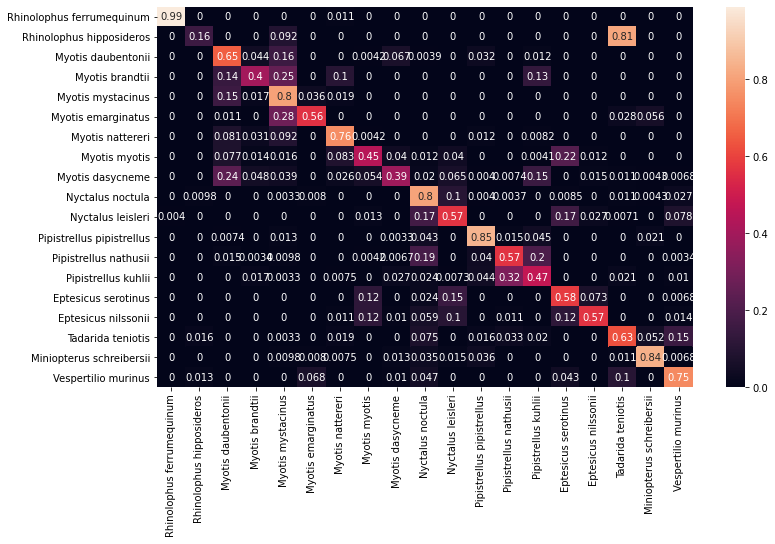

In [68]:
# Build confusion matrix
cf_matrix = confusion_matrix(Y_true, Y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=-1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('bat_1_cf.png')

In [69]:
from sklearn.metrics import f1_score
corrects = np.equal(Y_pred, Y_true).sum()
print("Test accuracy:", corrects/len(Y_pred))
print("F1-score:", f1_score(Y_true, Y_pred, average=None).mean())

Test accuracy: 0.6136900078678206
F1-score: 0.6124720145504066


In [70]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

1709459
